# MBA Admission

## About Dataset

## 1. Data Source
- Synthetic data generated from the Wharton Class of 2025's statistics.

## 2. Meta Data

- **application_id**: Unique identifier for each application.
- **gender**: Applicant's gender (`Male`, `Female`).
- **international**: International student status (`TRUE`/`FALSE`).
- **gpa**: Grade Point Average of the applicant (on a 4.0 scale).
- **major**: Undergraduate major (`Business`, `STEM`, `Humanities`).
- **race**: Racial background of the applicant (e.g., `White`, `Black`, `Asian`, `Hispanic`, `Other` / `null`: international student).
- **gmat**: GMAT score of the applicant (maximum of 800 points).
- **work_exp**: Number of years of work experience (in years).
- **work_industry**: Industry of the applicant's previous work experience (e.g., `Consulting`, `Finance`, `Technology`, etc.).
- **admission**: Admission status (`Admit`, `Waitlist`, `Null`: Deny).

## 3. Usage

- **Classification**: Predict the admission status based on other features.


In [31]:
# Importing important Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#  for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# model
from sklearn.tree import DecisionTreeClassifier

# Loading & Reading Data

In [32]:
df = pd.read_csv('MBA.csv')
df.head(20)

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN
5,6,Male,False,3.18,Business,White,610.0,6.0,Consulting,NaN
6,7,Female,False,2.93,STEM,Other,590.0,3.0,Technology,Admit
7,8,Male,True,3.02,Business,NaN,630.0,6.0,Financial Services,NaN
8,9,Male,False,3.24,Business,White,590.0,2.0,Nonprofit/Gov,NaN
9,10,Male,False,3.27,Humanities,Asian,690.0,3.0,Consulting,NaN


In [33]:
df.info

<bound method DataFrame.info of       application_id  gender  international   gpa       major      race  \
0                  1  Female          False  3.30    Business     Asian   
1                  2    Male          False  3.28  Humanities     Black   
2                  3  Female           True  3.30    Business       NaN   
3                  4    Male          False  3.47        STEM     Black   
4                  5    Male          False  3.35        STEM  Hispanic   
...              ...     ...            ...   ...         ...       ...   
6189            6190    Male          False  3.49    Business     White   
6190            6191    Male          False  3.18        STEM     Black   
6191            6192  Female           True  3.22    Business       NaN   
6192            6193    Male           True  3.36    Business       NaN   
6193            6194    Male          False  3.23        STEM  Hispanic   

       gmat  work_exp          work_industry admission  
0     620.

In [34]:
df.shape

(6194, 10)

In [35]:
df.describe()

,application_id,gpa,gmat,work_exp
count,6194.000000,6194.000000,6194.000000,6194.000000
mean,3097.500000,3.250714,651.092993,5.016952
std,1788.198115,0.151541,49.294883,1.032432
min,1.000000,2.650000,570.000000,1.000000
25%,1549.250000,3.150000,610.000000,4.000000
50%,3097.500000,3.250000,650.000000,5.000000
75%,4645.750000,3.350000,680.000000,6.000000
max,6194.000000,3.770000,780.000000,9.000000


# Data Cleaning and Exploration

In [36]:
# We can drop column "application_id", as being a unique identifier, it won't be providing us useful information!
df = df.drop('application_id', axis=1)

In [37]:
df.shape

(6194, 9)

In [38]:
#checking for missing Values
df.isna().sum()

gender              0
international       0
gpa                 0
major               0
race             1842
gmat                0
work_exp            0
work_industry       0
admission        5194
dtype: int64

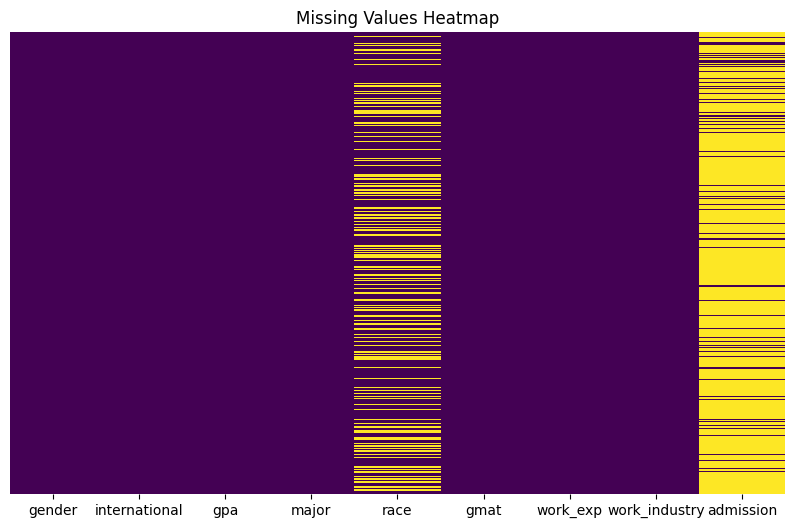

In [39]:
#plottin Heatmap for missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

It is evident that there are numerous missing values in columns like "Race" (1,842 missing values) and "Admission" (5,194 missing values). The missing values in the "Admission" column likely represent students who were not admitted, which makes sense in this context. However, for the "Race" column, it’s possible that the missing entries are from international students who may have left this question unanswered. Let's examine this in more detail.

In [13]:
total_missing_race = df['race'].isna().sum()

# 2. Count missing `race` values where `international` is TRUE
missing_race_international_true = df[df['race'].isna() & (df['international'] == True)].shape[0]

# 3. Count missing `race` values where `international` is FALSE
missing_race_international_false = df[df['race'].isna() & (df['international'] == False)].shape[0]

# 4. Calculate proportions
proportion_international_true = missing_race_international_true / total_missing_race
proportion_international_false = missing_race_international_false / total_missing_race

print("Total missing `race` values:", total_missing_race)
print("Missing `race` values where `international` is TRUE:", missing_race_international_true)
print("Missing `race` values where `international` is FALSE:", missing_race_international_false)
print("Proportion of missing `race` for international students (TRUE):", proportion_international_true)
print("Proportion of missing `race` for domestic students (FALSE):", proportion_international_false)

Total missing `race` values: 1842
Missing `race` values where `international` is TRUE: 1842
Missing `race` values where `international` is FALSE: 0
Proportion of missing `race` for international students (TRUE): 1.0
Proportion of missing `race` for domestic students (FALSE): 0.0


###  Missing Values analysis

As we suspected earlier, it is now clear that only international students left this question unanswered. 

Since these missing values are of the *"MAR"* (Missing at Random) type and cannot be ignored, we can impute them with terms like **"Other"** or **"Unknown"**, but we cannot simply drop them.



For the missing values in the *"Admission"* column, we can impute them with the term **"Not Admitted,"** which serves as the logical counterpart to **"Admitted."**


# Feature Engineering

In [45]:
# imputing 'others' into column 'race'
df["race"] = df["race"].fillna('others')
print(df["race"].unique())
print(df["race"].isna().sum())

['Asian' 'Black' 'others' 'Hispanic' 'White' 'Other']
0


In [46]:
# imputing 'not admitted' into col "admission"
df['admission'] = df['admission'].fillna('not admitted')
print(df['admission'].unique())
print(df['admission'].isna().sum())

['Admit' 'not admitted' 'Waitlist']
0
